<h1>Preprocessing Phase</h1>
<h3>1. Importing required Libraries</h3>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
sns.set()

C:\Users\MJ\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<h3>2. Loading Data from Raw CSV(s)</h3>

In [2]:
mandi_msp = pd.read_csv("CMO_MSP_Mandi.csv")
monthly_data_cmo = pd.read_csv("Monthly_data_cmo.csv")

<h3>3. Exploring Dataframes</h3>

<h5>a) Commodity Dataset (mandi_msp dataframe)</h5>

In [3]:
mandi_msp.info()
mandi_msp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 5 columns):
commodity     155 non-null object
year          155 non-null int64
Type          155 non-null object
msprice       145 non-null float64
msp_filter    155 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 6.1+ KB


,commodity,year,Type,msprice,msp_filter
0,PADDY-UNHUSKED,2012,Kharif Crops,1250.0,1
1,RICE(PADDY-HUS),2012,Kharif Crops,1280.0,1
2,Jowar_Hybrid,2012,Kharif Crops,1500.0,1
3,SORGUM(JAWAR),2012,Kharif Crops,1520.0,1
4,BAJRI,2012,Kharif Crops,1175.0,1


In [4]:
mandi_msp.shape

(155, 5)

<h5>There are 32 unique Commodities of 3 different types.</h5>

In [5]:
mandi_msp.describe(include="all")

,commodity,year,Type,msprice,msp_filter
count,155,155.000000,155,145.000000,155.0
unique,32,NaN,3,NaN,NaN
top,SPILT GERRN GRAM,NaN,Kharif Crops,NaN,NaN
freq,5,NaN,90,NaN,NaN
mean,NaN,2014.000000,NaN,2822.448276,1.0
std,NaN,1.418798,NaN,1441.725928,0.0
min,NaN,2012.000000,NaN,170.000000,1.0
25%,NaN,2013.000000,NaN,1470.000000,1.0
50%,NaN,2014.000000,NaN,2970.000000,1.0
75%,NaN,2015.000000,NaN,4000.000000,1.0


In [6]:
mandi_msp['msp_filter'].unique()

array([1], dtype=int64)

<h6>(Since msp_filter column has only one value, Lets drop the column itself as its not contributing essentially any new knowledge.) </h6>

In [7]:
mandi_msp.drop('msp_filter', axis=1, inplace=True) #Dropping msp_filter

<h6>(Handling Missing Values)</h6>

In [8]:
#Finding Number of missing Values
NA_mandi = mandi_msp.shape[0] - mandi_msp.dropna().shape[0]
print ("%d rows have missing values in the Mandi File data" %NA_mandi)

#Column having Missing Values
mandi_msp.isnull().sum()

#Null Rows
mandi_msp[mandi_msp.isnull().any(axis=1)]

10 rows have missing values in the Mandi File data


,commodity,year,Type,msprice
107,Soyabean_Black,2015,Kharif Crops,NaN
138,Soyabean_Black,2016,Kharif Crops,NaN
142,WHEAT(HUSKED),2016,Rabi Crops,NaN
143,WHEAT(UNHUSKED),2016,Rabi Crops,NaN
144,BARLI,2016,Rabi Crops,NaN
145,Gram_Yellow,2016,Rabi Crops,NaN
146,Masur_Yellow,2016,Rabi Crops,NaN
147,MUSTARD,2016,Rabi Crops,NaN
148,SAFFLOWER,2016,Rabi Crops,NaN
149,Toria_Yellow,2016,Rabi Crops,NaN


In [9]:
#Dropping Missing Values
mandi_msp.dropna(inplace=True)
mandi_msp.isnull().sum()

commodity    0
year         0
Type         0
msprice      0
dtype: int64

<h6>Further Modifications for Easy handling of Dataframe</h6>
<ol>
<li>Remove White Spaces
<li>Lowercasing the Data
</ol>

In [10]:
mandi_msp.commodity = mandi_msp.commodity.map(lambda x: x.lstrip(' '))
mandi_msp.commodity = mandi_msp.commodity.apply(lambda x: x.lower())

In [11]:
mandi_msp.to_csv('Mandi_msp_processed.csv', sep='\t', encoding='utf-8')
mandi_msp.head(5)

,commodity,year,Type,msprice
0,paddy-unhusked,2012,Kharif Crops,1250.0
1,rice(paddy-hus),2012,Kharif Crops,1280.0
2,jowar_hybrid,2012,Kharif Crops,1500.0
3,sorgum(jawar),2012,Kharif Crops,1520.0
4,bajri,2012,Kharif Crops,1175.0


<br><br>
<h5>b) Monthly Variation Dataset (monthly_data_cmo dataframe)</h5>

In [12]:
monthly_data_cmo.info()
monthly_data_cmo.head()
monthly_data_cmo.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62429 entries, 0 to 62428
Data columns (total 11 columns):
APMC               62429 non-null object
Commodity          62429 non-null object
Year               62429 non-null int64
Month              62429 non-null object
arrivals_in_qtl    62429 non-null int64
min_price          62429 non-null int64
max_price          62429 non-null int64
modal_price        62429 non-null int64
date               62429 non-null object
district_name      62429 non-null object
state_name         62429 non-null object
dtypes: int64(5), object(6)
memory usage: 5.2+ MB


(62429, 11)

In [13]:
monthly_data_cmo.describe()

,Year,arrivals_in_qtl,min_price,max_price,modal_price
count,62429.000000,6.242900e+04,6.242900e+04,6.242900e+04,62429.000000
mean,2015.337503,6.043088e+03,2.945228e+03,3.688814e+03,3296.003989
std,0.690451,3.470331e+04,1.318396e+04,7.662962e+03,3607.792534
min,2014.000000,1.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,2015.000000,3.800000e+01,1.250000e+03,1.600000e+03,1450.000000
50%,2015.000000,2.110000e+02,1.976000e+03,2.797000e+03,2425.000000
75%,2016.000000,1.364000e+03,3.900000e+03,4.647000e+03,4257.000000
max,2016.000000,1.450254e+06,3.153038e+06,1.600090e+06,142344.000000


<h6>(No missing values :)</h6>

In [14]:
NA_monthly = monthly_data_cmo.shape[0] - monthly_data_cmo.dropna().shape[0]
print ("%d rows have missing values in the Monthly File data" %NA_monthly)

0 rows have missing values in the Monthly File data


<h6>Further Modifications for Easy handling of Dataframe</h6>
<ol>
<li>Remove White Spaces
<li>Lowercasing the Data
</ol>

In [15]:
monthly_data_cmo.APMC = monthly_data_cmo.APMC.map(lambda x: x.lstrip(' '))
monthly_data_cmo.Commodity = monthly_data_cmo.Commodity.map(lambda x: x.lstrip(' '))
monthly_data_cmo.APMC = monthly_data_cmo.APMC.apply(lambda x: x.lower())
monthly_data_cmo.Commodity = monthly_data_cmo.Commodity.apply(lambda x: x.lower())

In [16]:
monthly_data_cmo.head()

,APMC,Commodity,Year,Month,arrivals_in_qtl,min_price,max_price,modal_price,date,district_name,state_name
0,ahmednagar,bajri,2015,April,79,1406,1538,1463,2015-04,Ahmadnagar,Maharashtra
1,ahmednagar,bajri,2016,April,106,1788,1925,1875,2016-04,Ahmadnagar,Maharashtra
2,ahmednagar,wheat(husked),2015,April,1253,1572,1890,1731,2015-04,Ahmadnagar,Maharashtra
3,ahmednagar,wheat(husked),2016,April,387,1750,2220,1999,2016-04,Ahmadnagar,Maharashtra
4,ahmednagar,sorgum(jawar),2015,April,3825,1600,2200,1900,2015-04,Ahmadnagar,Maharashtra


<br>
<br>
<br>
<h3>4) Visualizing Data to get some initial insights</h3>

<h5>Looking at the Distribution of points. (As well as Outliers)</h5>

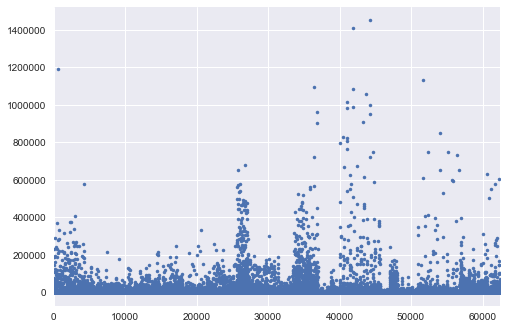

In [17]:
monthly_data_cmo['arrivals_in_qtl'].astype(float).plot(style=".") #Arrival Quantity

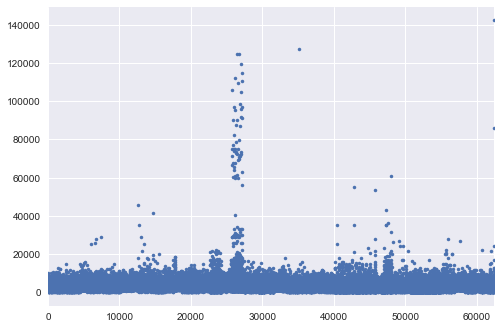

In [18]:
monthly_data_cmo['modal_price'].astype(float).plot(style=".") #Modal Price

<h3>Eliminating Outliers</h3> <h5>with Std. Dev >3 (In Monthly Dataset)</h5>

In [19]:
#Eliminating outliers with Standard Deviation(arrivals_in_qtl) >3
from scipy import stats
monthly_data_cmo=monthly_data_cmo[np.abs(monthly_data_cmo.arrivals_in_qtl-monthly_data_cmo.arrivals_in_qtl.mean())<=(3*monthly_data_cmo.arrivals_in_qtl.std())]

In [20]:
#Eliminating outliers with Standard Deviation(modal_price) >3
monthly_data_cmo=monthly_data_cmo[np.abs(monthly_data_cmo.modal_price-monthly_data_cmo.modal_price.mean())<=(3*monthly_data_cmo.modal_price.std())]
#Eliminating outliers with Standard Deviation(max and min price) >3
monthly_data_cmo=monthly_data_cmo[np.abs(monthly_data_cmo.min_price-monthly_data_cmo.min_price.mean())<=(3*monthly_data_cmo.min_price.std())]
monthly_data_cmo=monthly_data_cmo[np.abs(monthly_data_cmo.max_price-monthly_data_cmo.max_price.mean())<=(3*monthly_data_cmo.max_price.std())]

monthly_data_cmo.to_csv('monthly_data_cmo_no_outliers.csv', sep='\t', encoding='utf-8')

<h5>Changes in the DIstribution after dropping Outliers. (Look how the plot is more dense now as the extreme values have been dropped)</h5>

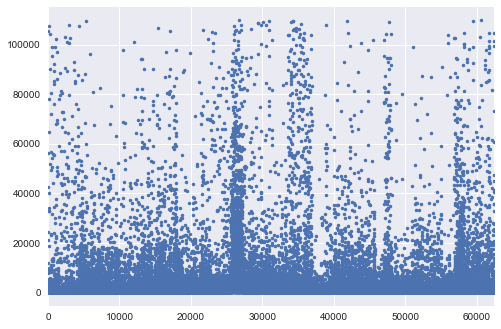

In [21]:
monthly_data_cmo['arrivals_in_qtl'].astype(float).plot(style=".") #Arrival Quantity

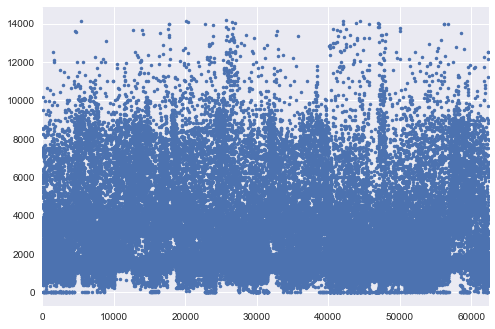

In [22]:
monthly_data_cmo['modal_price'].astype(float).plot(style=".") #Arrival Quantity

<h5>Observing Price Distribution Graphs</h5>

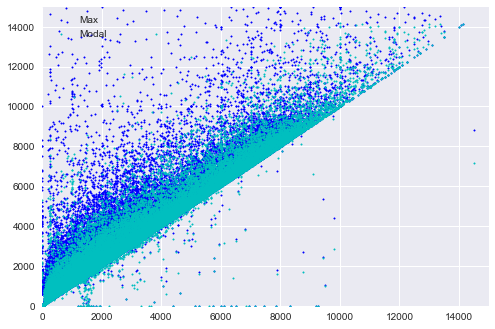

In [23]:
tempscatter = monthly_data_cmo.sort_values(by=['Commodity'])

# tempscatter = monthly_data_cmo.sort_values(by=['Commodity']).plot.scatter(x = 'min_price', y = 'modal_price')
# ax = monthly_data_cmo.sort_values(by=['Commodity']).plot.scatter(x = 'min_price', y = 'modal_price')

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_xlim(0, 15000)
ax1.set_ylim(0, 15000)
ax1.scatter(tempscatter['min_price'], tempscatter['max_price'], s=10, c='b', marker=".", label='Max')
ax1.scatter(tempscatter['min_price'],tempscatter['modal_price'], s=10, c='c', marker=".", label='Modal')
plt.legend(loc='upper left');
plt.show()

<h5>Seeing distribution of Commodity Dataset</h5>

<h5>Q) Wonder why Kharif crops have greater participation than Rabi?<br>
A) Kharif is the Monsoon Season. That's why. Rabi is the Winter season.
</h5>

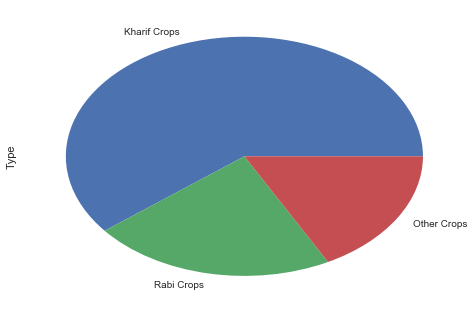

In [24]:
(mandi_msp['Type'].value_counts()/len(mandi_msp)).plot(kind="pie") #Type of Crops

<h6>Q) Wonder why the last recurring pattern in the below sequence looks awkward?<br>
A) Remember the Null Values we dropped earlier in the preprocessing stage? Yeah, thats it.
</h6>

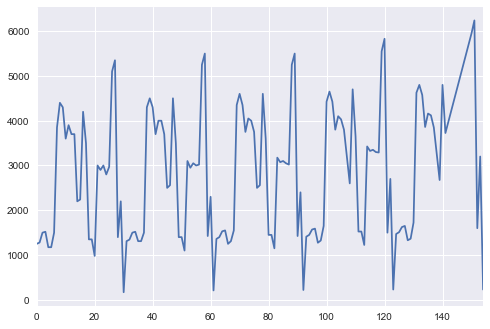

In [25]:
mandi_msp['msprice'].plot(style="-")

<h1>Time Series Analysis</h1>


<h5>Having a look at the Dataset of monthly distribution, the clear points to keep in mind is -</h5>
<ol>
<li>Quantity and Price Values (MIN, MAX and MODAL) are given corresponding to APMC, Commodity and Time (Year-Month or Date)
<li>Year and Month columns can be dropped as Date column is sufficient for holding their information.
<li>State and District Columns can also be dropped as they give no beneficial information as to cunducting this time-series analysis.
</ol>
<br>
<h5>Note: Keeping these points in mind, the only possible logical study would be analyse a particular APMC and Commodity. Also, since this analysis would be generic in nature, this analysis could be done for any cluster of APMC and Commodity.</h5>

<h3>1) Watching the Varitation of Price Ranges.</h3>

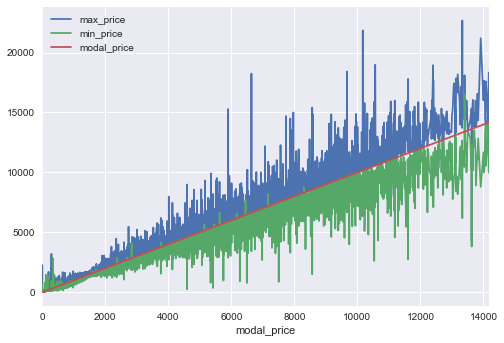

In [26]:
monthly_data_cmo.dropna().groupby('modal_price')[[ 'max_price', 'min_price', 'modal_price']].agg('mean').plot()

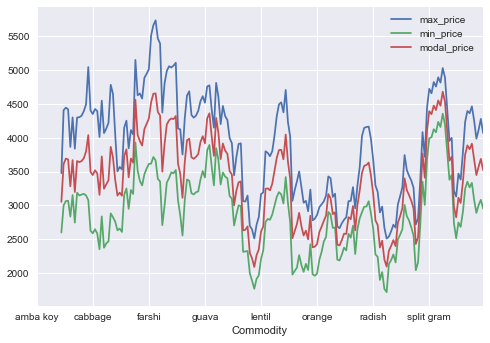

In [27]:
monthly_data_cmo.dropna().groupby('Commodity')[[ 'max_price', 'min_price', 'modal_price']].agg('mean').rolling(window = 12).agg('mean').plot()

<h3>2) Writing a function for stationarity analysis.</h3>

<h5>A generic function for plotting Rolling Statistics. This will plot Moving Mean and Standard Deviation.
<br></h5>
<h3>Dickey-fuller Test</h3>
<h5>
This is one of the statistical tests for checking stationarity. <br><br>
Null hypothesis: the Time Series is Non-Stationary. The result from this Test will contain the test statistic and critical value for different confidence levels. <br><br>
The idea is to have Test statistics less than critical value, in which case we can reject the null hypothesis and say that this Time series is indeed stationary.
</h5>

In [28]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)
    
    #Plot rolling statistics
    
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    
    #Perform Dickey-Fuller test:
    
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

<h5>Funtion to Visualize the Seasonality and Trend</h5>

In [29]:
def pred(mandi, commodity):
    
    #Slicing data on the basis of a particular Mandi and Commodity
    temp_df = monthly_data_cmo[monthly_data_cmo['APMC'] == mandi]
    temp_df = temp_df[temp_df['Commodity'] == commodity]
    
    temp_df.date = pd.to_datetime(temp_df.date)
    temp_df.set_index('date', inplace=True)
    temp_df=temp_df.sort_index()

#     plt.plot(temp_df['arrivals_in_qtl']*temp_df['modal_price'])
#     plt.xlabel('Year', fontsize=12);
#     plt.ylabel('Average price of '+commodity+' in '+mandi, fontsize=12);
    
    #Convert to Time-Series Object:
    ts = temp_df['modal_price']
    
    #Studying Trend - logarithmic transformation
    ts_log=np.log(ts)
    
    #reduction of noise using moving average
    moving_avg=pd.rolling_mean(ts_log,12)
             
    expweighted_avg = pd.ewma(ts_log,halflife=12) #halflife is assumed 12
             
    #subtracting exponential weighted mean from the original series and plotting it
    ts_log_ewma_diff = ts_log - expweighted_avg
     
    #Seasonality Analysis

    #Differencing by taking difference using time lag
    #Taking First Difference

    ts_log_diff = ts_log - ts_log.shift()
    ts_log_diff.dropna(inplace=True)
             
    #Decomposition
    from statsmodels.tsa.seasonal import seasonal_decompose
    decomposition = seasonal_decompose(ts_log)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    
    plt.subplot(411)
    plt.plot(ts_log, label="Original")
    plt.legend(loc="best")
    plt.subplot(412)
    plt.plot(trend, label="Trend")
    plt.legend(loc="best")
    plt.subplot(413)
    plt.plot(seasonal, label="Seasonality")
    plt.legend(loc="best")
    plt.subplot(414)
    plt.plot(residual, label="Residuals")
    plt.legend(loc="best")
    plt.tight_layout()
             
    ts_log_decompose = residual
    ts_log_decompose.dropna(inplace=True)
    test_stationarity(ts_log_decompose)

Results of Dickey-Fuller Test:
Test Statistic                 0.000000
p-value                        0.958532
#Lags Used                     8.000000
Number of Observations Used    6.000000
Critical Value (1%)           -5.354256
Critical Value (5%)           -3.646238
Critical Value (10%)          -2.901198
dtype: float64


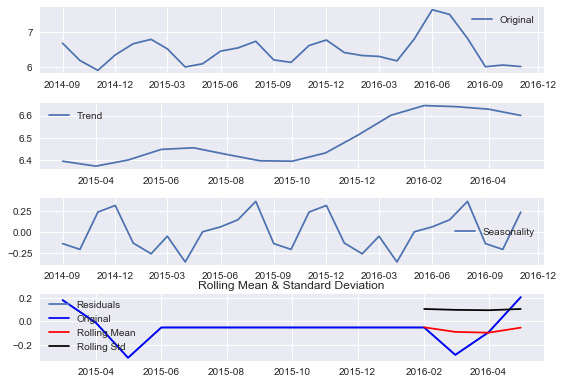

In [30]:
pred('aurangabad','cabbage')

<h6>Function to detect Seasonality (Additive or Multiplicative)</h6>

In [31]:
def detect_seasonality(data_filter):
    
    data_filter["trend"]=data_filter["modal_price"].rolling(window=2).mean()

    data_filter["detrended_additive"]=data_filter["modal_price"]-data_filter["trend"]
    data_filter["detrended_multiplicative"]=data_filter["modal_price"]/data_filter["trend"]

    additive_mean=data_filter[["detrended_additive","quarter"]].groupby(["quarter"]).mean().to_dict()["detrended_additive"]
    multiplicative_mean=data_filter[["detrended_multiplicative","quarter"]].groupby(["quarter"]).mean().to_dict()["detrended_multiplicative"]

    data_filter["seasonal_additive"]=data_filter["quarter"].apply(lambda x: additive_mean[x])
    data_filter["seasonal_multiplicative"]=data_filter["quarter"].apply(lambda x: multiplicative_mean[x])

    data_filter["residual_additive"]=data_filter["detrended_additive"]-data_filter["seasonal_additive"]
    data_filter["residual_multiplicative"]=data_filter["detrended_multiplicative"]-data_filter["seasonal_multiplicative"]

    additive_acf=sum(np.asarray(acf(data_filter["residual_additive"], missing='drop'))*2)
    multiplicative_acf=sum(np.asarray(acf(data_filter["residual_multiplicative"], missing='drop'))*2)

    if additive_acf<multiplicative_acf:
        return "Additive"
    else:
        return "Multiplicative"

<h5>Organizing the monthly database a little.</h5>

In [32]:
monthly_data_cmo_deseasonal=monthly_data_cmo.copy()
monthly_data_cmo_deseasonal["date"]=pd.to_datetime(monthly_data_cmo_deseasonal["date"])
monthly_data_cmo_deseasonal["quarter"]=monthly_data_cmo_deseasonal["date"].dt.quarter
monthly_data_cmo_deseasonal["combined_label"]=monthly_data_cmo_deseasonal["APMC"]+":"+monthly_data_cmo_deseasonal["Commodity"]
monthly_data_cmo_deseasonal.head()

,APMC,Commodity,Year,Month,arrivals_in_qtl,min_price,max_price,modal_price,date,district_name,state_name,quarter,combined_label
0,ahmednagar,bajri,2015,April,79,1406,1538,1463,2015-04-01,Ahmadnagar,Maharashtra,2,ahmednagar:bajri
1,ahmednagar,bajri,2016,April,106,1788,1925,1875,2016-04-01,Ahmadnagar,Maharashtra,2,ahmednagar:bajri
2,ahmednagar,wheat(husked),2015,April,1253,1572,1890,1731,2015-04-01,Ahmadnagar,Maharashtra,2,ahmednagar:wheat(husked)
3,ahmednagar,wheat(husked),2016,April,387,1750,2220,1999,2016-04-01,Ahmadnagar,Maharashtra,2,ahmednagar:wheat(husked)
4,ahmednagar,sorgum(jawar),2015,April,3825,1600,2200,1900,2015-04-01,Ahmadnagar,Maharashtra,2,ahmednagar:sorgum(jawar)


<h5>Storing the Seasonality for each APMC-Commodity cluster.</h5>

In [33]:
data=monthly_data_cmo_deseasonal[["APMC","Commodity","modal_price","Year","combined_label"]].groupby(["APMC","Commodity","Year","combined_label"],as_index=False).count().rename(columns={"modal_price":"Count"}).reset_index(drop=True)
data=data[data["Count"]==12].reset_index(drop=True)
filterlist=data["combined_label"].unique().tolist()
monthly_data_cmo_deseasonal=monthly_data_cmo_deseasonal[monthly_data_cmo_deseasonal["combined_label"].isin(filterlist)].reset_index(drop=True)

commodities=list(monthly_data_cmo_deseasonal["combined_label"].unique())
seasonality_type=[]
for commodity in commodities:
    data_filter=monthly_data_cmo_deseasonal[monthly_data_cmo_deseasonal["combined_label"]==commodity]
    seasonality_type.append((commodity,detect_seasonality(data_filter)))

commodity_seasonality=pd.DataFrame(seasonality_type,columns=["Commodity","Seasonality Type"])

In [34]:
commodity_seasonality.to_csv('Commodity_seasonality.csv', sep='\t', encoding='utf-8')
commodity_seasonality.head()

,Commodity,Seasonality Type
0,akole:bajri,Multiplicative
1,akole:paddy-unhusked,Multiplicative
2,akole:wheat(husked),Multiplicative
3,akole:gram,Additive
4,akole:soybean,Multiplicative


<h6>Function to find deseasonalised price values based on seasonality (Additive ot Multiplicative)</h6>

In [35]:
def deseasonalise_values(data_filter,value):
    data_filter["trend"]=data_filter["modal_price"].rolling(window=2).mean()
    
    if (value=="Additive"):
        data_filter["detrended_additive"]=data_filter["modal_price"]-data_filter["trend"]
        additive_mean=data_filter[["detrended_additive","quarter"]].groupby(["quarter"]).mean().to_dict()["detrended_additive"]
        data_filter["seasonal_additive"]=data_filter["quarter"].apply(lambda x: additive_mean[x])
        values=data_filter["modal_price"]-data_filter["seasonal_additive"]
        values=values.tolist()
        
    else:
        data_filter["detrended_multiplicative"]=data_filter["modal_price"]/data_filter["trend"]
        multiplicative_mean=data_filter[["detrended_multiplicative","quarter"]].groupby(["quarter"]).mean().to_dict()["detrended_multiplicative"]
        data_filter["seasonal_multiplicative"]=data_filter["quarter"].apply(lambda x: multiplicative_mean[x])
        values=data_filter["modal_price"]/data_filter["seasonal_multiplicative"]
        values=values.tolist()
        
    indexes=data_filter.index.tolist()

    values_range=range(0,len(values))
    
    for index,value in zip(indexes,values_range):
        
        data_filter.at[index,"deseasonalise_price"]=values[value]
        
    return data_filter[["APMC","Commodity","combined_label","date","modal_price","quarter","deseasonalise_price"]]

In [36]:
monthly_data_cmo_deseasonal["deseasonalise_price"]=np.nan
commkeys=dict(sorted(commodity_seasonality.values.tolist())).keys()
commodities=dict(sorted(commodity_seasonality.values.tolist()))

data_deseasonalised=pd.DataFrame() 
for commodity in commkeys:
    data_temp=deseasonalise_values(monthly_data_cmo_deseasonal[monthly_data_cmo_deseasonal["combined_label"]==commodity],commodities[commodity])
    data_deseasonalised=pd.concat([data_deseasonalised,data_temp])

In [37]:
data_deseasonalised.to_csv('Deseasonalised_prices.csv', sep='\t', encoding='utf-8')
data_deseasonalised.head()

,APMC,Commodity,combined_label,date,modal_price,quarter,deseasonalise_price
6909,aamgaon,paddy-unhusked,aamgaon:paddy-unhusked,2015-04-01,1412,2,1401.887208
6910,aamgaon,paddy-unhusked,aamgaon:paddy-unhusked,2016-04-01,1657,2,1645.132509
6913,aamgaon,paddy-unhusked,aamgaon:paddy-unhusked,2015-08-01,1562,3,1532.240681
6914,aamgaon,paddy-unhusked,aamgaon:paddy-unhusked,2016-08-01,1667,3,1635.240215
6917,aamgaon,paddy-unhusked,aamgaon:paddy-unhusked,2014-12-01,1518,4,1549.982472


<h1>Comparing Prices in APMC with MSP (Raw and Deseasonlized)</h1>

In [38]:
commodity_msp=mandi_msp.groupby(['commodity'],as_index=False).mean()
commodity_msp = commodity_msp.drop('year', 1)
commodity_msp.reset_index(drop=True, inplace=True)

MSP_Commodity = dict(sorted(commodity_msp.values.tolist()))
MSP_Commodity

{'bajri': 1268.0,
 'barli': 1113.75,
 'coconut': 1470.0,
 'copra (ball)_yellow': 5684.0,
 'copra (milling)_yellow': 5420.0,
 'cotton': 3742.0,
 'cotton_long staple': 4042.0,
 'gr.nut kernels': 3970.0,
 'gram_yellow': 3175.0,
 'jowar_hybrid': 1545.0,
 'jute_yellow': 2560.0,
 'maize': 1297.0,
 'masur_yellow': 3062.5,
 'mustard': 3125.0,
 'niger-seed': 3595.0,
 'paddy-unhusked': 1360.0,
 'pigeon pea (tur)': 4310.0,
 'ragi_maldandi': 1585.0,
 'rice(paddy-hus)': 1397.0,
 'safflower': 3037.5,
 'sesamum': 4560.0,
 'sorgum(jawar)': 1566.0,
 'soyabean': 2527.0,
 'soyabean_black': 2400.0,
 'spilt gerrn gram': 4590.0,
 'split black gram': 4390.0,
 'sugar-cane': 207.5,
 'sugarcane': 230.0,
 'sunflower': 3760.0,
 'toria_yellow': 3075.0,
 'wheat(husked)': 1431.25,
 'wheat(unhusked)': 1431.25}

<h5>Dividing Monthly Data into separate Years</h5>

In [39]:
monthly_data_cmo_2014=monthly_data_cmo[monthly_data_cmo['Year']==2014]
monthly_data_cmo_2015=monthly_data_cmo[monthly_data_cmo['Year']==2015]
monthly_data_cmo_2016=monthly_data_cmo[monthly_data_cmo['Year']==2016]

<h5>Comparing Prices Commodity-wise for a particular year (Ex: 2014)</h5>

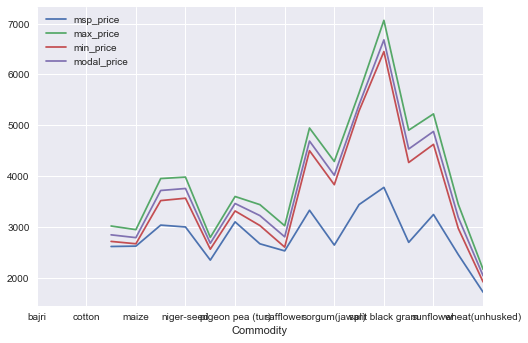

In [40]:
monthly_2014=monthly_data_cmo_2014.groupby(['Commodity'],as_index=False).mean()
monthly_2014.drop(['Year','arrivals_in_qtl'],1,inplace=True)

monthly_2014['msp_price'] = monthly_2014['Commodity'].apply(lambda x : MSP_Commodity[x] if x in list(MSP_Commodity.keys()) else np.nan)

monthly_2014.dropna().groupby('Commodity')[[ 'msp_price', 'max_price', 'min_price', 'modal_price']].agg('mean').rolling(window = 4).agg('mean').plot()

<h5>Now Comparing Price variations of a particular APMC, Commodity over the years.</h5>

In [41]:
def price_variation(APMC,Commodity):
    
    monthly_data_cmo_test=monthly_data_cmo[monthly_data_cmo['APMC']==APMC.lower()]
    monthly_data_cmo_test=monthly_data_cmo_test[monthly_data_cmo_test['Commodity']==Commodity.lower()]
    
    monthly_data_cmo_test.drop(['date','district_name','state_name','arrivals_in_qtl'],inplace=True,errors='ignore')
    monthly_data_cmo_test=monthly_data_cmo_test.groupby(['Year'],as_index=False)[[ 'Year','max_price', 'min_price', 'modal_price']].agg('mean')
    
    mandi_msp_test=mandi_msp[mandi_msp['commodity']==Commodity.lower()]
    mandi_msp_test.drop(['Type','commodity'],1,inplace=True,errors='ignore')
    
    temp_df = pd.merge(mandi_msp_test, monthly_data_cmo_test, how="inner", left_on=["year"], right_on =["Year"])
    temp_df.groupby('year')['msprice','modal_price','min_price','max_price'].agg('mean').plot(title=Commodity+" in "+APMC, xticks=temp_df['year'])

<h5>Note: Since the Data is for less number of years, the plot looks very simple and inconclusive</h5>

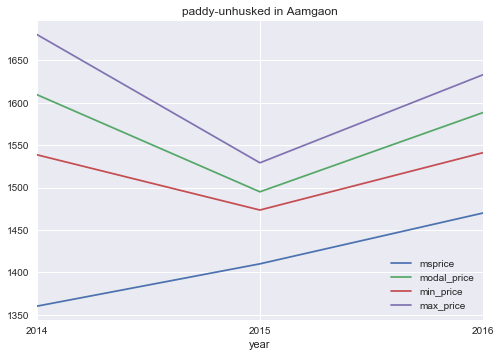

In [42]:
price_variation('Aamgaon','paddy-unhusked')

<h6>Comparing Prices for all APMCs and Commodities</h6>

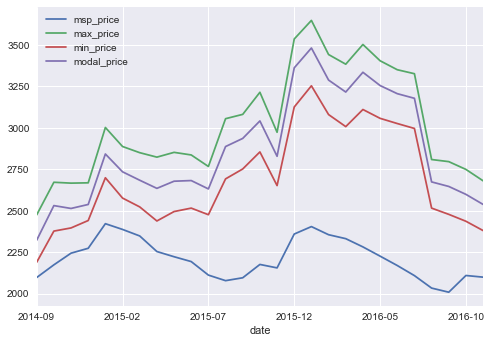

In [43]:
commodity_msp=mandi_msp.groupby(['commodity'],as_index=False).mean()
commodity_msp = commodity_msp.drop('year', 1)
commodity_msp.reset_index(drop=True, inplace=True)
MSP_Commodity = dict(sorted(commodity_msp.values.tolist()))

monthly_data_cmo['msp_price'] = monthly_data_cmo['Commodity'].apply(lambda x : MSP_Commodity[x] if x in list(MSP_Commodity.keys()) else np.nan)
monthly_data_cmo.dropna().groupby('date')[[ 'msp_price', 'max_price', 'min_price', 'modal_price']].agg('mean').plot()

<h5>Comparing Deseasonal Prices for the entire data of APMC and Commodities</h5>

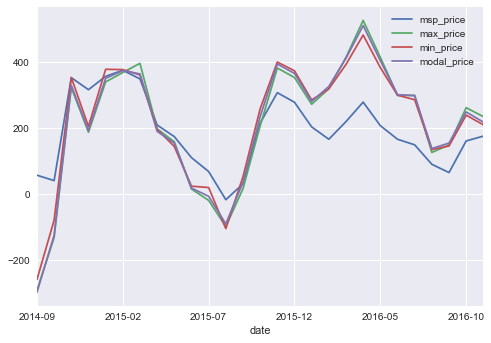

In [44]:
shifted=monthly_data_cmo.copy()
shifted.head()
shifted[['max_price', 'min_price', 'modal_price', 'msp_price']]=(shifted[['max_price', 'min_price', 'modal_price', 'msp_price']] - shifted[['max_price', 'min_price', 'modal_price', 'msp_price']].shift(-2))
shifted.dropna().groupby(['date'])[[ 'msp_price', 'max_price', 'min_price', 'modal_price']].agg('mean').plot()

<h5>Comparing Deseasonal Prices for individual APMC and commodity</h5>

In [45]:
def deseasonal_individual(APMC,Commodity):
    source=data_deseasonalised[data_deseasonalised["combined_label"]==(APMC+':'+Commodity)].sort_values('date')
    plt.plot(source['date'],source['modal_price'])
    plt.plot(source['date'],source['deseasonalise_price'])
    plt.xlabel(Commodity+' in '+APMC)
    plt.ylabel('Price Range')
    plt.show()   

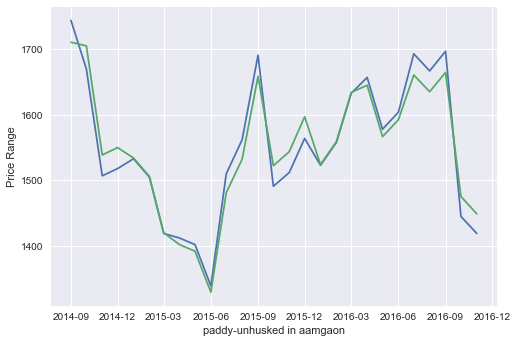

In [46]:
deseasonal_individual('aamgaon','paddy-unhusked')

<h1>Flag set of APMC/mandis and commodities with highest price fluctuation across different commodities in each relevant season, and year.</h1>

<h5>Organizing the dataset a little.</h5>

In [47]:
monthly_data_cmo_fluctuation=monthly_data_cmo.copy()
monthly_data_cmo_fluctuation["date"]=pd.to_datetime(monthly_data_cmo_fluctuation["date"])
monthly_data_cmo_fluctuation["combined_label"]=monthly_data_cmo_fluctuation["APMC"]+":"+monthly_data_cmo_fluctuation["Commodity"]

<h5>Notice the count = 35 in the 25% row</h5>

In [48]:
monthly_data_cmo_fluctuation.groupby('APMC')['max_price'].agg(['count', 'mean']).describe() # 35 (25th percentile)

,count,mean
count,348.000000,348.000000
mean,176.316092,3585.427525
std,219.283817,1104.701757
min,1.000000,309.132075
25%,35.000000,2814.675146
50%,115.000000,3608.809551
75%,216.500000,4372.815278
max,1433.000000,7500.000000


<h5>Top 25-percentile APMC and Commodities with highest price fluctuation</h5>

In [49]:
data=[]
commodities=monthly_data_cmo_fluctuation["combined_label"].unique().tolist()
for commodity in commodities:
    temp=monthly_data_cmo_fluctuation[monthly_data_cmo_fluctuation["combined_label"]==commodity]
    value=stats.variation(temp["max_price"])
    data.append((commodity,value))
data.sort(key=lambda x: x[1],reverse= True)
data=[x[0] for x in data[:35]] #25th percentile

data

['ratanagari:coriander  ',
 'pune:shepu',
 'ramtek:mosambi',
 'tadkalas:sorgum(jawar)',
 'tadkalas:wheat(husked)',
 'tadkalas:gram',
 'tadkalas:green gram',
 'tadkalas:pigeon pea (tur)',
 'akluj:lemon',
 'akluj:coriander  ',
 'pune-pimpri:shepu',
 'karad:math (bhaji)',
 'ulhasnagar:coconut',
 'vadgaon peth:coriander  ',
 'barshi:shevga',
 'chandrapur:pineapple',
 'karad:coriander  ',
 'kolhapur:raddish',
 'barshi:chikoo',
 'barshi:brinjal',
 'barshi:tomato',
 'kalyan:spinach',
 'kalyan:math (bhaji)',
 'khed:kanda pat',
 'barshi:cabbage',
 'pune-pimpri:coriander  ',
 'barshi:green chilli',
 'barshi:flower',
 'rahata:cabbage',
 'barshi:lemon',
 'barshi:cluster bean',
 'khed-chakan:shepu',
 'nagpur:lemon',
 'barshi:cucumber',
 'pune:lemon']

In [50]:
temp = pd.DataFrame({'APMC-Commodity':data})
temp.to_csv('Highest_Fluctuation_Commodity_APMC.csv', sep='\t', encoding='utf-8')

<h5>APMCs and Commodities with highest price fluctuation across different commodities in each relevant season, and year.</h5>

In [51]:
data_main=pd.DataFrame()
for commodity in data:
    value=monthly_data_cmo_fluctuation[monthly_data_cmo_fluctuation["combined_label"]==commodity]["max_price"].std()*3
    df_temp=monthly_data_cmo_fluctuation[(monthly_data_cmo_fluctuation["combined_label"]==commodity)&(monthly_data_cmo_fluctuation["max_price"]>value)]
    df_temp=df_temp[["APMC","Commodity","Month","Year","max_price"]]
    data_main=pd.concat([data_main,df_temp])
data_main.reset_index(drop=True)

print(data_main)

data_main.to_csv('Highest_Fluctuation_Season_Year.csv', sep='\t', encoding='utf-8')

               APMC     Commodity      Month  Year  max_price
46764    ratanagari   coriander         June  2016       1263
52735         akluj   coriander         June  2015       3200
23594  vadgaon peth   coriander        March  2015        100
52493        barshi        shevga       July  2016       5000
15333    chandrapur     pineapple   February  2016        568
23433      kolhapur       raddish       June  2015       6350
52783        barshi        chikoo       June  2016       3880
53433        barshi        chikoo        May  2016       2970
54207        barshi       brinjal    October  2016       4163
52496        barshi        tomato       July  2016       2445
52483        barshi       cabbage       July  2016       1486
52507        barshi  green chilli       July  2016       5190
52472        barshi        flower       July  2016       1641
54171        barshi        flower    October  2016       1447
1928         rahata       cabbage       July  2016       2015
54656   

<h5>Notice that APMCs on the left side (Ex: Biloli, Barshi, etc.) have much more fluctuation than those on the right (Ex: mukhed, khed, etc.)</h5>

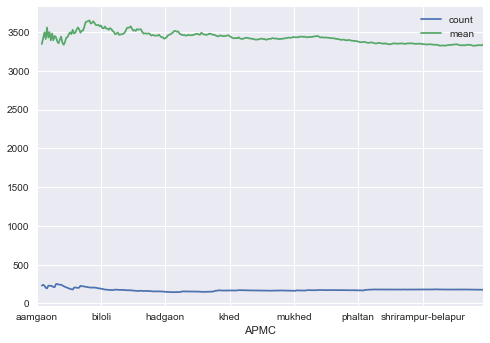

In [52]:
monthly_data_cmo_fluctuation.groupby('APMC')['modal_price'].agg(['count', 'mean']).expanding(min_periods = 5).agg('mean').plot()